In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
from Models.parallel_model import ParallelModel
import numpy as np
from flow import Flow
from estimator import ImportanceSampling

In [16]:
def create_base_model(input_shape=1, output_shape=1):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = tf.keras.layers.Dense(512, activation='relu')(inputs)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(output_shape, activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)


In [17]:
base_model = create_base_model()
parallel_model = ParallelModel(base_model, 10)

In [18]:
flow = Flow(
    prior = None,
    likelihood_std=0.1, 
    k=0.01,
    n_epochs_recorded= 5
)

flow.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    lr = 0.01,
    metrics=['accuracy']
)

In [19]:
X_train = tf.cast(np.linspace(0, 1, 1000).reshape(-1, 1), tf.float32)
y_train = tf.cast(np.sin(X_train * 2 * np.pi).reshape(-1, 1), tf.float32)

In [ ]:
w, log_q, log_p = flow.flow(
    model = parallel_model,
    x = X_train,
    y = y_train,
    batch_size = 128,
    epochs=50)

Training Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]

In [ ]:
estimator = ImportanceSampling(
    weights=w,
    logq = log_q,
    logp = log_p
)

In [ ]:
x_pred = np.linspace(0, 1, 100)
mean, var = estimator(x_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


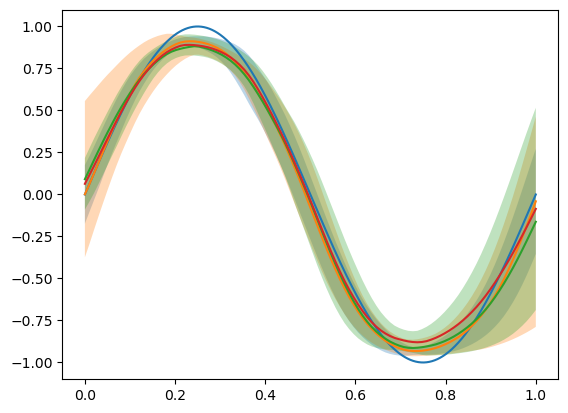

In [23]:
y_pred = parallel_model.predict(X_train)
import matplotlib.pyplot as plt

# i=2
plt.plot(X_train, y_train, label='true')
for i in range(0, len(mean), 2):
    plt.plot(x_pred, mean[i])
    plt.fill_between(x_pred, mean[i] - 1.96*np.sqrt(var[i]), mean[i] + 1.96*np.sqrt(var[i]), alpha = 0.3)
plt.show()